# 한글 설정

In [2]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv

Hit:1 https://mirror.kakao.com/ubuntu focal InRelease
Get:2 https://mirror.kakao.com/ubuntu focal-updates InRelease [128 kB]
Get:3 https://mirror.kakao.com/ubuntu focal-backports InRelease [128 kB]
Get:4 https://mirror.kakao.com/ubuntu focal-security InRelease [128 kB]
0% [Working]                      ^C
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/tr

# 데이터 확인하기

## metadata.csv 확인 및 EDA

In [ ]:
import pandas as pd
from pathlib import Path

meta_path = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata.csv")

df = pd.read_csv(meta_path)

# 1. 데이터 기본 정보 확인
print("데이터 크기 : ", df.shape)
print("\n컬럼 이름 : \n", df.columns.tolist())
print("\n데이터 타입 : =n")
print(df.dtypes)

데이터 크기 :  (1019, 15)

컬럼 이름 : 
 ['file_name', 'video_path', 'subdir', 'width', 'height', 'codec', 'fps', 'duration_sec', 'num_frames', 'frames_dir', 'n_extracted_frames', 'keypoints_dir', 'frames_verified', 'sapiens_done', 'exists']

데이터 타입 : =n
file_name              object
video_path             object
subdir                 object
width                   int64
height                  int64
codec                  object
fps                   float64
duration_sec          float64
num_frames              int64
frames_dir             object
n_extracted_frames      int64
keypoints_dir          object
frames_verified         int64
sapiens_done            int64
exists                  int64
dtype: object


## test용 test_video_metadata.csv 생성
나중에 metadata가 변경되면 안되기 때문에 test_video_metadata.csv를 생성한다.

In [ ]:
# 조건 : sapiens를 모두 돌린 sample_data 내부의 비디오들
df_filtered = df[(df["sapiens_done"] == 1) & (df["subdir"].str.contains("sample_data"))]

# 새로운 csv로 저장 및 df 최신화
csv_out_path = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/test_video_metadata.csv")
df_filtered.to_csv(csv_out_path, index=False)

print(f"✅ 저장 완료: {csv_out_path.resolve()}")
print("📌 행 개수:", df_filtered.shape[0])
print("📌 포함된 subdir 목록:", df_filtered["subdir"].unique())

df_test = pd.read_csv(csv_out_path)

✅ 저장 완료: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/test_video_metadata.csv
📌 행 개수: 75
📌 포함된 subdir 목록: ['sample_data/ward_sample_video' 'sample_data/ICU_sample_video']


## 결측 JSON 확인 및 metadata update
그중에서도 결측치가 많은 것들만 확인

In [ ]:
import os
import pandas as pd
from pathlib import Path
import ast

# CSV 불러오기
test_meta_path = Path("../data/new_data/test_video_metadata.csv")
df_test = pd.read_csv(test_meta_path)

# 프레임-JSON 비교 함수
def compare_frames_and_json(row):
    frames_dir = row["frames_dir"]
    keypoints_dir = row["keypoints_dir"]

    if not (isinstance(frames_dir, str) and os.path.isdir(frames_dir)):
        return 0, []
    if not (isinstance(keypoints_dir, str) and os.path.isdir(keypoints_dir)):
        return 0, []

    # 프레임 파일 목록
    frame_files = sorted(
        [os.path.splitext(f)[0] for f in os.listdir(frames_dir) if f.lower().endswith((".jpg", ".png"))]
    )
    # JSON 파일 목록
    json_files = sorted(
        [os.path.splitext(f)[0] for f in os.listdir(keypoints_dir) if f.endswith(".json")]
    )

    # 매칭 실패한 프레임
    missing = sorted(set(frame_files) - set(json_files))

    return len(json_files), missing

# -------------------------
# 1. 새로운 컬럼 추가
# -------------------------
df_test[["n_json_files", "missing_frames"]] = df_test.apply(
    lambda row: pd.Series(compare_frames_and_json(row)), axis=1
)

# json_ratio 추가
df_test["json_ratio"] = df_test["n_json_files"] / df_test["n_extracted_frames"]

# -------------------------
# 2. CSV 저장
# -------------------------
out_path = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")
df_test.to_csv(out_path, index=False)
print(f"✅ 저장 완료: {out_path.resolve()}")

# -------------------------
# 3. 저장된 파일 다시 불러오기
# -------------------------
df_loaded = pd.read_csv(out_path)

# missing_frames 문자열 → 리스트로 복원
df_loaded["missing_frames"] = df_loaded["missing_frames"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)

# -------------------------
# 4. json_ratio != 1 인 데이터 확인 (5개만)
# -------------------------
df_check = df_loaded[df_loaded["json_ratio"] != 1].head(5)
print("📌 json_ratio != 1 인 샘플 (5개)")
print(df_check[["file_name", "n_extracted_frames", "n_json_files", "json_ratio", "missing_frames"]])


✅ 저장 완료: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/test_video_metadata_with_jsoncheck.csv
📌 json_ratio != 1 인 샘플 (5개)
                           file_name  n_extracted_frames  n_json_files  \
7               17_누워서 번갈아 다리 들기.MOV                 436           434   
8               18_누워서 무릎 굽혔다 펴기.MOV                 528           497   
9       19_경사진 침대에서 다리 구부리기 (양쪽).MOV                 489           485   
11  20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV                 458           364   
13                 22-1_브릿지 (동적).MOV                 269           265   

    json_ratio                                     missing_frames  
7     0.995413                                   [000136, 000405]  
8     0.941288  [000031, 000032, 000300, 000301, 000302, 00030...  
9     0.991820                   [000291, 000292, 000366, 000436]  
11    0.794760  [000044, 000045, 000052, 000058, 000059, 00012...  
13    0.985130                   [000008, 0000

## 결측 JSON에 한하여 sapiens 재실행
### 기존 detector 사용시
결과적으로 실패해서 새로운 detector 방법 고안 중

In [ ]:
# #!/usr/bin/env python   # 파이썬 실행 환경 지정
# # -*- coding: utf-8 -*-  # UTF-8 인코딩 명시

# """
# rerun_one_missing_sapiens.py

# 📌 기능:
# - test_video_metadata_with_jsoncheck.csv 불러오기
# - missing_frames 있는 비디오 중 첫 번째 하나만 선택
# - 전체 프레임에 대해 Sapiens 다시 실행
# """

# import os, cv2, json, ast
# import numpy as npa
# import pandas as pd
# from pathlib import Path
# from tqdm import tqdm

# # ---------------- 외부 라이브러리 ----------------
# from mmdet.apis import init_detector, inference_detector
# from mmpose.apis import init_model as init_pose_estimator, inference_topdown
# from mmpose.utils import adapt_mmdet_pipeline
# from mmpose.evaluation.functional import nms
# from mmpose.structures import merge_data_samples, split_instances
# import mmpretrain  # ViT 등록용

# # ---------------- 경로 ----------------
# CHECK_CSV_PATH = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")

# DET_CONFIG  = "../sapiens/pose/demo/mmdetection_cfg/rtmdet_m_640-8xb32_coco-person_no_nms.py"
# DET_CKPT    = "../sapiens/pose/checkpoints/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth"
# POSE_CONFIG = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
# POSE_CKPT   = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"

# # ---------------- 유틸 ----------------
# def to_py(obj):
#     """넘파이 객체를 JSON 직렬화 가능한 타입으로 변환"""
#     import numpy as _np
#     if isinstance(obj, _np.ndarray): return obj.tolist()
#     if isinstance(obj, (_np.floating,)): return float(obj)
#     if isinstance(obj, (_np.integer,)):  return int(obj)
#     if isinstance(obj, dict):  return {k: to_py(v) for k, v in obj.items()}
#     if isinstance(obj, (list, tuple)): return [to_py(v) for v in obj]
#     return obj

# # ---------------- Sapiens 실행 ----------------
# def run_sapiens_on_missing_frames(video_row, detector, pose_estimator, missing_frames):
#     """누락된 프레임만 Sapiens 실행"""
#     video_filename = video_row["file_name"]
#     frame_dir = Path(video_row["frames_dir"])
#     if not frame_dir.exists():
#         print(f"[SKIP] 프레임 폴더 없음: {video_filename}")
#         return

#     # JSON 저장 경로
#     json_dir = Path(video_row["keypoints_dir"]) / f"{Path(video_filename).stem}_JSON"
#     json_dir.mkdir(parents=True, exist_ok=True)

#     created_count = 0  # ✅ 새로 만든 JSON 개수 카운트

#     for idx_frame in tqdm(missing_frames, desc=f"{video_filename} (missing only)", unit="frame"):
#         idx_frame = int(idx_frame)  # 문자열일 경우 정수 변환
#         fpath = frame_dir / f"{idx_frame:06d}.jpg"
#         json_path = json_dir / f"{idx_frame:06d}.json"

#         if json_path.exists():
#             continue  # 이미 JSON 있으면 스킵

#         if not fpath.exists():
#             print(f"[WARN] 프레임 없음: {fpath}")
#             continue

#         img_bgr = cv2.imread(str(fpath))
#         if img_bgr is None:
#             print(f"[WARN] 이미지 읽기 실패: {fpath}")
#             continue

#         img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#         try:
#             det = inference_detector(detector, img_rgb)
#             pred = det.pred_instances.cpu().numpy()
#             keep = (pred.labels == 0) & (pred.scores > 0.5)
#             bbs = np.concatenate((pred.bboxes, pred.scores[:, None]), axis=1)[keep]
#             if len(bbs) == 0:
#                 continue
#             bbs = bbs[nms(bbs, 0.5), :4]

#             pose_results = inference_topdown(pose_estimator, img_rgb, bbs)
#             data_sample = merge_data_samples(pose_results)
#             inst = data_sample.get("pred_instances", None)
#             if inst is None:
#                 continue
#             inst_list = split_instances(inst)

#             payload = dict(frame_index=idx_frame, video_name=video_filename,
#                            meta_info=pose_estimator.dataset_meta, instance_info=inst_list)

#             with open(json_path, "w", encoding="utf-8") as f:
#                 json.dump(to_py(payload), f, ensure_ascii=False, indent=2)

#             created_count += 1  # ✅ 새로 만든 JSON 개수 증가

#         except Exception as e:
#             print(f"[ERROR] {video_filename} frame {idx_frame} → {e}")

#     print(f"[INFO] {video_filename} → 새로 생성된 JSON 파일 수: {created_count}")


# # ---------------- 메인 ----------------
# def main():
#     if not CHECK_CSV_PATH.exists():
#         print(f"[ERROR] {CHECK_CSV_PATH} 없음")
#         return

#     df = pd.read_csv(CHECK_CSV_PATH)

#     # Detector / Pose Estimator 초기화
#     detector = init_detector(DET_CONFIG, DET_CKPT, device="cuda:0")
#     detector.cfg = adapt_mmdet_pipeline(detector.cfg)
#     pose_estimator = init_pose_estimator(
#         POSE_CONFIG, POSE_CKPT, device="cuda:0",
#         cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False)))
#     )

#     # missing_frames 있는 비디오 하나 찾기
#     target_found = False
#     for idx, row in df.iterrows():
#         # missing_frames 문자열 → 리스트 변환
#         missing = []
#         if isinstance(row.get("missing_frames", []), str):
#             try:
#                 missing = ast.literal_eval(row["missing_frames"])
#             except Exception:
#                 missing = []
#         else:
#             missing = row.get("missing_frames", [])

#         # 누락된 프레임이 있으면 실행
#         if isinstance(missing, list) and len(missing) > 0:
#             print(f"[RE-RUN ONE] {row['file_name']} → 누락 프레임 {len(missing)}개")
#             run_sapiens_on_missing_frames(row, detector, pose_estimator, missing)
#             target_found = True
#             break  # 첫 번째 대상만 실행 후 종료

#     if not target_found:
#         print("[INFO] missing_frames 있는 비디오 없음. 실행 스킵.")



# # ---------------- 실행 ----------------
# if __name__=="__main__":
#     main()


/opt/conda/lib/python3.10/importlib/__init__.py:169: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _bootstrap._exec(spec, module)


Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var

[RE-RUN ONE] 17_누워서 번갈아 다리 들기.MOV → 누락 프레임 2개


17_누워서 번갈아 다리 들기.MOV (missing only): 100% 2/2 [00:00<00:00, 11.87frame/s]

[INFO] 17_누워서 번갈아 다리 들기.MOV → 새로 생성된 JSON 파일 수: 0


### 가까운 Frame 에서 Bbox 추출 후 제공
Detector 부분을 제거하고 그냥 BBox

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
rerun_missing_with_interp_json.py

📌 기능:
- test_video_metadata_with_jsoncheck.csv 불러오기
- missing_frames 있는 비디오에 대해 누락된 프레임만 처리
- detector 대신 기존 JSON에서 bbox를 재활용
- 생성된 JSON은 interp_json 디렉토리에 저장 (raw_data의 subdir 구조 유지)
- 실행 후 CSV에 interp_json_dir, n_interp_json_files 업데이트
"""

import cv2, json, ast
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ---------------- 외부 라이브러리 ----------------
from mmpose.apis import init_model as init_pose_estimator, inference_topdown
from mmpose.structures import merge_data_samples, split_instances
import mmpretrain  # ViT 등록용

# ---------------- 경로 ----------------
CHECK_CSV_PATH = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")
INTERP_ROOT = Path("../data/new_data/interp_json")

POSE_CONFIG = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
POSE_CKPT   = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"

# ---------------- 유틸 ----------------
def to_py(obj):
    """넘파이 객체를 JSON 직렬화 가능한 타입으로 변환"""
    import numpy as _np
    if isinstance(obj, _np.ndarray): return obj.tolist()
    if isinstance(obj, (_np.floating,)): return float(obj)
    if isinstance(obj, (_np.integer,)):  return int(obj)
    if isinstance(obj, dict):  return {k: to_py(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_py(v) for v in obj]
    return obj

def find_closest_json(idx_frame, orig_json_dir, search_range=10):
    """주변에서 가장 가까운 JSON 탐색"""
    for offset in range(1, search_range+1):
        for candidate in [
            orig_json_dir / f"{idx_frame-offset:06d}.json",
            orig_json_dir / f"{idx_frame+offset:06d}.json"
        ]:
            if candidate.exists():
                return candidate
    return None

# ---------------- Sapiens 실행 ----------------
def run_interp_on_missing_frames(video_row, pose_estimator, missing_frames, df, idx):
    """누락된 프레임만 bbox 재활용해서 Sapiens 실행"""
    video_filename = video_row["file_name"]
    frame_dir = Path(video_row["frames_dir"])
    if not frame_dir.exists():
        print(f"[SKIP] 프레임 폴더 없음: {video_filename}")
        return df

    # 기존 JSON 디렉토리 (원본 keypoints)
    orig_json_dir = Path(video_row["keypoints_dir"]) / f"{Path(video_filename).stem}_JSON"

    # interp_json 경로 생성
    subdir = Path(video_row["subdir"])
    interp_json_dir = INTERP_ROOT / subdir / f"{Path(video_filename).stem}_JSON"
    interp_json_dir.mkdir(parents=True, exist_ok=True)

    created_count = 0
    for idx_frame in tqdm(missing_frames, desc=f"{video_filename} (interp)", unit="frame"):
        idx_frame = int(idx_frame)
        fpath = frame_dir / f"{idx_frame:06d}.jpg"
        json_path = interp_json_dir / f"{idx_frame:06d}.json"

        if json_path.exists() or not fpath.exists():
            continue

        # 가장 가까운 JSON에서 bbox 가져오기
        neighbor_json = find_closest_json(idx_frame, orig_json_dir, search_range=10)
        if neighbor_json is None:
            continue

        with open(neighbor_json, "r", encoding="utf-8") as f:
            neighbor_data = json.load(f)
        if not neighbor_data["instance_info"]:
            continue

        bbox = neighbor_data["instance_info"][0]["bbox"]
        if isinstance(bbox[0], (list, tuple)):
            bbox = bbox[0]
        bbox = np.array(bbox, dtype=np.float32).reshape(1, 4)

        # 이미지 읽기
        img_bgr = cv2.imread(str(fpath))
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # 포즈 추론
        pose_results = inference_topdown(pose_estimator, img_rgb, bbox)
        data_sample = merge_data_samples(pose_results)
        inst = data_sample.get("pred_instances", None)
        if inst is None:
            continue
        inst_list = split_instances(inst)

        payload = dict(
            frame_index=idx_frame,
            video_name=video_filename,
            meta_info=pose_estimator.dataset_meta,
            instance_info=inst_list
        )
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(to_py(payload), f, ensure_ascii=False, indent=2)

        created_count += 1

    # CSV 업데이트
    n_interp_json_files = len(list(interp_json_dir.glob("*.json")))
    df.loc[idx, "interp_json_dir"] = str(interp_json_dir)
    df.loc[idx, "n_interp_json_files"] = n_interp_json_files

    print(f"[INFO] {video_filename} → 새 JSON {created_count}개, 총 {n_interp_json_files}개")
    return df

# ---------------- 메인 ----------------
def main():
    if not CHECK_CSV_PATH.exists():
        print(f"[ERROR] {CHECK_CSV_PATH} 없음")
        return

    df = pd.read_csv(CHECK_CSV_PATH)

    # Pose Estimator 초기화 (detector 제거)
    pose_estimator = init_pose_estimator(
        POSE_CONFIG, POSE_CKPT, device="cuda:0",
        cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False)))
    )

    updated = False
    for idx, row in df.iterrows():
        missing = []
        if isinstance(row.get("missing_frames", []), str):
            try:
                missing = ast.literal_eval(row["missing_frames"])
            except Exception:
                missing = []
        else:
            missing = row.get("missing_frames", [])

        if isinstance(missing, list) and len(missing) > 0:
            print(f"[RE-RUN] {row['file_name']} → 누락 {len(missing)}개")
            df = run_interp_on_missing_frames(row, pose_estimator, missing, df, idx)
            updated = True

    if updated:
        df.to_csv(CHECK_CSV_PATH, index=False, encoding="utf-8-sig")
        print(f"[INFO] CSV 업데이트 완료 → {CHECK_CSV_PATH}")

if __name__ == "__main__":
    main()


Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var

[RE-RUN] 17_누워서 번갈아 다리 들기.MOV → 누락 2개


17_누워서 번갈아 다리 들기.MOV (interp): 100% 2/2 [00:00<00:00, 36.75frame/s]


[INFO] 17_누워서 번갈아 다리 들기.MOV → 새 JSON 0개, 총 2개
[RE-RUN] 18_누워서 무릎 굽혔다 펴기.MOV → 누락 31개


18_누워서 무릎 굽혔다 펴기.MOV (interp): 100% 31/31 [00:00<00:00, 181.19frame/s]


[INFO] 18_누워서 무릎 굽혔다 펴기.MOV → 새 JSON 0개, 총 31개
[RE-RUN] 19_경사진 침대에서 다리 구부리기 (양쪽).MOV → 누락 4개


19_경사진 침대에서 다리 구부리기 (양쪽).MOV (interp): 100% 4/4 [00:00<00:00, 259.22frame/s]


[INFO] 19_경사진 침대에서 다리 구부리기 (양쪽).MOV → 새 JSON 0개, 총 4개
[RE-RUN] 20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV → 누락 94개


20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV (interp): 100% 94/94 [00:00<00:00, 192.58frame/s]


[INFO] 20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV → 새 JSON 0개, 총 83개
[RE-RUN] 22-1_브릿지 (동적).MOV → 누락 4개


22-1_브릿지 (동적).MOV (interp): 100% 4/4 [00:00<00:00, 1684.97frame/s]


[INFO] 22-1_브릿지 (동적).MOV → 새 JSON 0개, 총 4개
[RE-RUN] 22_경사진 침대에서 브릿지 (동적).MOV → 누락 3개


22_경사진 침대에서 브릿지 (동적).MOV (interp): 100% 3/3 [00:00<00:00, 2103.11frame/s]


[INFO] 22_경사진 침대에서 브릿지 (동적).MOV → 새 JSON 0개, 총 3개
[RE-RUN] 23-1_브릿지 (정적).MOV → 누락 27개


23-1_브릿지 (정적).MOV (interp): 100% 27/27 [00:00<00:00, 133.59frame/s]


[INFO] 23-1_브릿지 (정적).MOV → 새 JSON 0개, 총 22개
[RE-RUN] 23_경사진 침대에서 브릿지 (정적).MOV → 누락 4개


23_경사진 침대에서 브릿지 (정적).MOV (interp): 100% 4/4 [00:00<00:00, 2378.73frame/s]


[INFO] 23_경사진 침대에서 브릿지 (정적).MOV → 새 JSON 0개, 총 4개
[RE-RUN] 26_몸통과 하체 돌리기.MOV → 누락 2개


26_몸통과 하체 돌리기.MOV (interp): 100% 2/2 [00:00<00:00, 1756.41frame/s]


[INFO] 26_몸통과 하체 돌리기.MOV → 새 JSON 0개, 총 2개
[RE-RUN] 27_누운 자세에서 자전거 타기.MOV → 누락 2개


27_누운 자세에서 자전거 타기.MOV (interp): 100% 2/2 [00:00<00:00, 1880.85frame/s]


[INFO] 27_누운 자세에서 자전거 타기.MOV → 새 JSON 0개, 총 2개
[RE-RUN] 30_의자에서 앉았다 일어나기 (지지대 o)_high walker.MOV → 누락 1개


30_의자에서 앉았다 일어나기 (지지대 o)_high walker.MOV (interp): 100% 1/1 [00:00<00:00, 1328.15frame/s]


[INFO] 30_의자에서 앉았다 일어나기 (지지대 o)_high walker.MOV → 새 JSON 0개, 총 1개
[RE-RUN] 경사진 침대에서 가슴 열기.MP4 → 누락 69개


경사진 침대에서 가슴 열기.MP4 (interp): 100% 69/69 [00:00<00:00, 287.91frame/s]


[INFO] 경사진 침대에서 가슴 열기.MP4 → 새 JSON 0개, 총 69개
[RE-RUN] 경사진 침대에서 누워 자전거 타기.MP4 → 누락 159개


경사진 침대에서 누워 자전거 타기.MP4 (interp): 100% 159/159 [00:00<00:00, 586.54frame/s]


[INFO] 경사진 침대에서 누워 자전거 타기.MP4 → 새 JSON 0개, 총 159개
[RE-RUN] 경사진 침대에서 몸통 돌리기.MP4 → 누락 18개


경사진 침대에서 몸통 돌리기.MP4 (interp): 100% 18/18 [00:00<00:00, 1285.70frame/s]


[INFO] 경사진 침대에서 몸통 돌리기.MP4 → 새 JSON 0개, 총 18개
[RE-RUN] 경사진 침대에서 무릎 펴서 번갈아 다리 들기_1.MP4 → 누락 62개


경사진 침대에서 무릎 펴서 번갈아 다리 들기_1.MP4 (interp): 100% 62/62 [00:00<00:00, 347.30frame/s]


[INFO] 경사진 침대에서 무릎 펴서 번갈아 다리 들기_1.MP4 → 새 JSON 0개, 총 62개
[RE-RUN] 경사진 침대에서 무릎 펴서 번갈아 다리 들기_2.MP4 → 누락 127개


경사진 침대에서 무릎 펴서 번갈아 다리 들기_2.MP4 (interp): 100% 127/127 [00:00<00:00, 264.65frame/s]


[INFO] 경사진 침대에서 무릎 펴서 번갈아 다리 들기_2.MP4 → 새 JSON 0개, 총 127개
[RE-RUN] 경사진 침대에서 바로 누워 클램쉘.MP4 → 누락 134개


경사진 침대에서 바로 누워 클램쉘.MP4 (interp): 100% 134/134 [00:00<00:00, 217.09frame/s]


[INFO] 경사진 침대에서 바로 누워 클램쉘.MP4 → 새 JSON 0개, 총 114개
[RE-RUN] 경사진 침대에서 발목 번갈아 움직이기.MP4 → 누락 27개


경사진 침대에서 발목 번갈아 움직이기.MP4 (interp): 100% 27/27 [00:00<00:00, 170.44frame/s]


[INFO] 경사진 침대에서 발목 번갈아 움직이기.MP4 → 새 JSON 0개, 총 27개
[RE-RUN] 경사진 침대에서 번갈아 다리 구부리기.MP4 → 누락 170개


경사진 침대에서 번갈아 다리 구부리기.MP4 (interp): 100% 170/170 [00:00<00:00, 429.35frame/s]


[INFO] 경사진 침대에서 번갈아 다리 구부리기.MP4 → 새 JSON 0개, 총 170개
[RE-RUN] 경사진 침대에서 번갈아 다리 들기.MP4 → 누락 55개


경사진 침대에서 번갈아 다리 들기.MP4 (interp): 100% 55/55 [00:00<00:00, 590.94frame/s]


[INFO] 경사진 침대에서 번갈아 다리 들기.MP4 → 새 JSON 0개, 총 55개
[RE-RUN] 경사진 침대에서 번갈아 무릎 구부렸다 펴기.MP4 → 누락 36개


경사진 침대에서 번갈아 무릎 구부렸다 펴기.MP4 (interp): 100% 36/36 [00:00<00:00, 309.74frame/s]


[INFO] 경사진 침대에서 번갈아 무릎 구부렸다 펴기.MP4 → 새 JSON 0개, 총 36개
[RE-RUN] 경사진 침대에서 번갈아 옆으로 다리 내리기.MP4 → 누락 218개


경사진 침대에서 번갈아 옆으로 다리 내리기.MP4 (interp): 100% 218/218 [00:00<00:00, 276.27frame/s]


[INFO] 경사진 침대에서 번갈아 옆으로 다리 내리기.MP4 → 새 JSON 0개, 총 146개
[RE-RUN] 경사진 침대에서 보조 목 뒤에 손 두고 윗몸일으키기.MP4 → 누락 56개


경사진 침대에서 보조 목 뒤에 손 두고 윗몸일으키기.MP4 (interp): 100% 56/56 [00:00<00:00, 510.03frame/s]


[INFO] 경사진 침대에서 보조 목 뒤에 손 두고 윗몸일으키기.MP4 → 새 JSON 0개, 총 56개
[RE-RUN] 경사진 침대에서 브릿지_1.MP4 → 누락 224개


경사진 침대에서 브릿지_1.MP4 (interp): 100% 224/224 [00:00<00:00, 287.01frame/s]


[INFO] 경사진 침대에서 브릿지_1.MP4 → 새 JSON 0개, 총 108개
[RE-RUN] 경사진 침대에서 브릿지_2.MP4 → 누락 226개


경사진 침대에서 브릿지_2.MP4 (interp): 100% 226/226 [00:00<00:00, 379.92frame/s]


[INFO] 경사진 침대에서 브릿지_2.MP4 → 새 JSON 0개, 총 157개
[RE-RUN] 경사진 침대에서 브릿지_유지하기.MP4 → 누락 243개


경사진 침대에서 브릿지_유지하기.MP4 (interp): 100% 243/243 [00:00<00:00, 323.29frame/s]


[INFO] 경사진 침대에서 브릿지_유지하기.MP4 → 새 JSON 0개, 총 56개
[RE-RUN] 경사진 침대에서 양쪽 팔꿈치 굽히기(탄력밴드).MP4 → 누락 50개


경사진 침대에서 양쪽 팔꿈치 굽히기(탄력밴드).MP4 (interp): 100% 50/50 [00:00<00:00, 1085.01frame/s]


[INFO] 경사진 침대에서 양쪽 팔꿈치 굽히기(탄력밴드).MP4 → 새 JSON 0개, 총 50개
[RE-RUN] 경사진 침대에서 양쪽 팔꿈치 굽히기_1.MP4 → 누락 22개


경사진 침대에서 양쪽 팔꿈치 굽히기_1.MP4 (interp): 100% 22/22 [00:00<00:00, 366.73frame/s]


[INFO] 경사진 침대에서 양쪽 팔꿈치 굽히기_1.MP4 → 새 JSON 0개, 총 22개
[RE-RUN] 경사진 침대에서 양쪽 팔꿈치 굽히기_2.MP4 → 누락 31개


경사진 침대에서 양쪽 팔꿈치 굽히기_2.MP4 (interp): 100% 31/31 [00:00<00:00, 3392.83frame/s]


[INFO] 경사진 침대에서 양쪽 팔꿈치 굽히기_2.MP4 → 새 JSON 0개, 총 31개
[RE-RUN] 경사진 침대에서 양팔 앞으로 올리기.MP4 → 누락 39개


경사진 침대에서 양팔 앞으로 올리기.MP4 (interp): 100% 39/39 [00:00<00:00, 1081.25frame/s]


[INFO] 경사진 침대에서 양팔 앞으로 올리기.MP4 → 새 JSON 0개, 총 39개
[RE-RUN] 경사진 침대에서 양팔 옆으로 들기.MP4 → 누락 7개


경사진 침대에서 양팔 옆으로 들기.MP4 (interp): 100% 7/7 [00:00<00:00, 2737.29frame/s]


[INFO] 경사진 침대에서 양팔 옆으로 들기.MP4 → 새 JSON 0개, 총 7개
[RE-RUN] 경사진 침대에서 어깨 돌리기.MP4 → 누락 27개


경사진 침대에서 어깨 돌리기.MP4 (interp): 100% 27/27 [00:00<00:00, 854.38frame/s]


[INFO] 경사진 침대에서 어깨 돌리기.MP4 → 새 JSON 0개, 총 27개
[RE-RUN] 경사진 침대에서 체스트 프레스(탄력밴드).MP4 → 누락 22개


경사진 침대에서 체스트 프레스(탄력밴드).MP4 (interp): 100% 22/22 [00:00<00:00, 653.83frame/s]


[INFO] 경사진 침대에서 체스트 프레스(탄력밴드).MP4 → 새 JSON 0개, 총 22개
[RE-RUN] 경사진 침대에서 체스트 프레스.MP4 → 누락 33개


경사진 침대에서 체스트 프레스.MP4 (interp): 100% 33/33 [00:00<00:00, 1027.97frame/s]


[INFO] 경사진 침대에서 체스트 프레스.MP4 → 새 JSON 0개, 총 33개
[RE-RUN] 경사진 침대에서 팔 수평 벌리기(탄력밴드).MP4 → 누락 66개


경사진 침대에서 팔 수평 벌리기(탄력밴드).MP4 (interp): 100% 66/66 [00:00<00:00, 971.85frame/s]


[INFO] 경사진 침대에서 팔 수평 벌리기(탄력밴드).MP4 → 새 JSON 0개, 총 66개
[RE-RUN] 경사진 침대에서 팔 위로 뻗어 옆으로 벌리기(탄력밴드).MP4 → 누락 6개


경사진 침대에서 팔 위로 뻗어 옆으로 벌리기(탄력밴드).MP4 (interp): 100% 6/6 [00:00<00:00, 2368.77frame/s]


[INFO] 경사진 침대에서 팔 위로 뻗어 옆으로 벌리기(탄력밴드).MP4 → 새 JSON 0개, 총 6개
[RE-RUN] 경사진 침대에서 팔꿈치 펴 팔 앞으로 모으기.MP4 → 누락 15개


경사진 침대에서 팔꿈치 펴 팔 앞으로 모으기.MP4 (interp): 100% 15/15 [00:00<00:00, 444.83frame/s]


[INFO] 경사진 침대에서 팔꿈치 펴 팔 앞으로 모으기.MP4 → 새 JSON 0개, 총 15개
[INFO] CSV 업데이트 완료 → ../data/new_data/test_video_metadata_with_jsoncheck.csv


## overlay 실행
### 시각화

Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



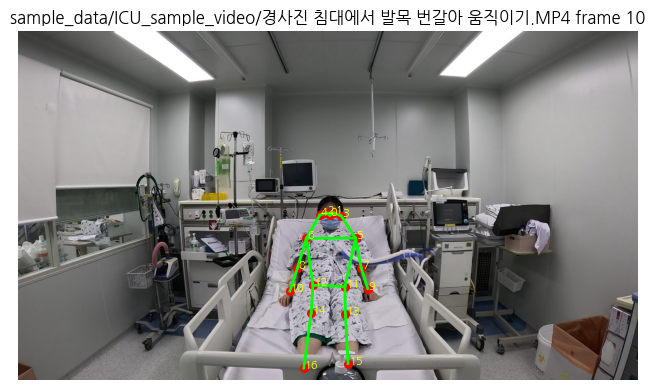

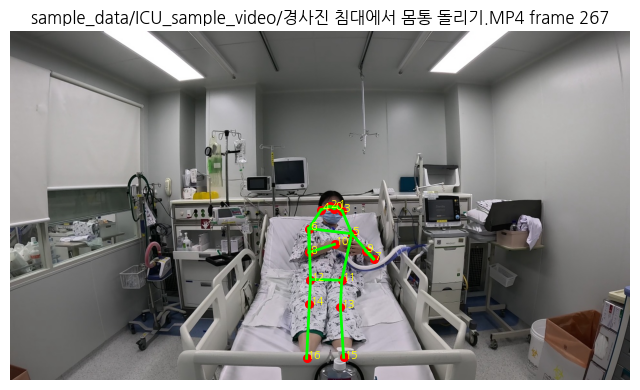

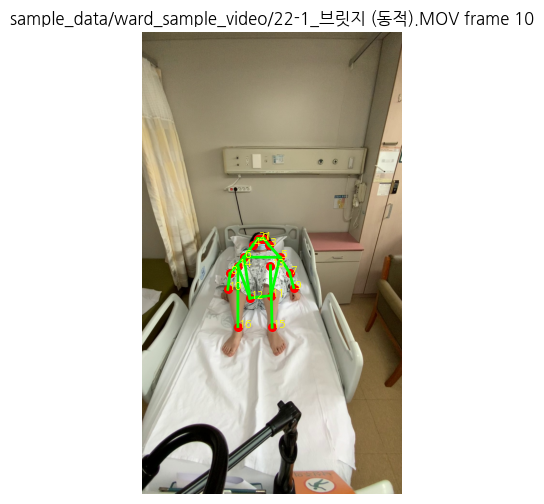

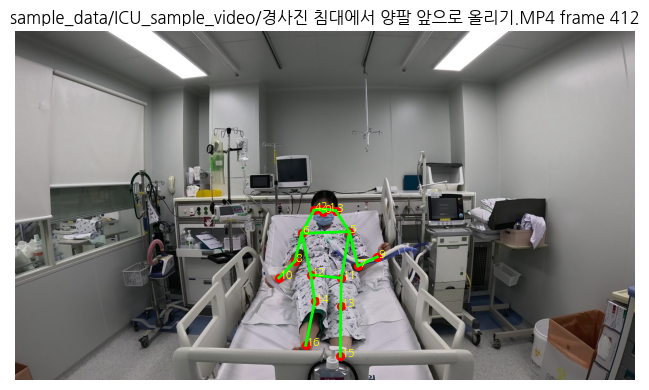

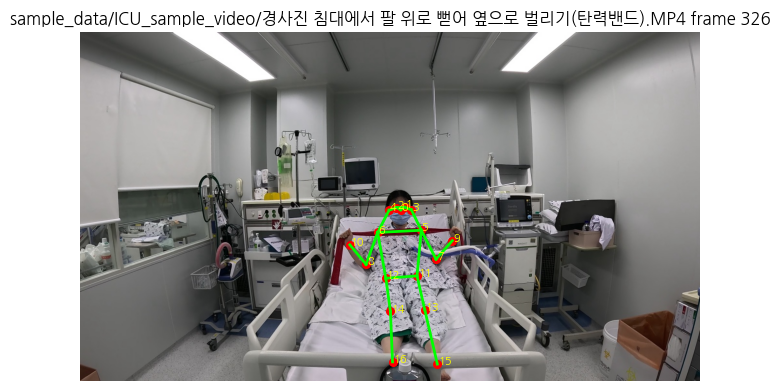

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
visualize_random_incomplete_interp_json.py

📌 기능:
- CSV(test_video_metadata_with_jsoncheck.csv)에서 json_ratio < 1 인 비디오만 추출
- 그 중 랜덤 5개 선택
- 각 비디오의 interp_json에서 랜덤 JSON 1개 시각화
- keypoint 라벨은 숫자(index)로 표시
"""

import cv2, json, ast, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from mmpose.apis import init_model as init_pose_estimator

# ---------------- 경로 ----------------
CSV_PATH   = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")
INTERP_ROOT = Path("../data/new_data/interp_json")

POSE_CONFIG = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
POSE_CKPT   = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"

# ---------------- Pose Estimator 초기화 ----------------
pose_estimator = init_pose_estimator(
    POSE_CONFIG, POSE_CKPT, device="cuda:0",
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False)))
)

skeleton = pose_estimator.dataset_meta["skeleton_links"]

# ---------------- CSV 불러오기 ----------------
df = pd.read_csv(CSV_PATH)

# ratio < 1 인 데이터만 필터링
df_incomplete = df[df["json_ratio"] < 1]

# 랜덤 5개 선택
sampled_rows = df_incomplete.sample(5, random_state=42)

for _, row in sampled_rows.iterrows():
    file_name = row["file_name"]
    subdir    = row["subdir"]
    interp_json_dir = INTERP_ROOT / subdir / f"{Path(file_name).stem}_JSON"

    if not interp_json_dir.exists():
        print(f"[SKIP] {interp_json_dir} 없음")
        continue

    # interp_json 디렉토리에서 JSON 하나 랜덤 선택
    json_files = list(interp_json_dir.glob("*.json"))
    if not json_files:
        print(f"[SKIP] JSON 없음: {interp_json_dir}")
        continue

    json_path = random.choice(json_files)
    idx_frame = int(json_path.stem)
    frame_path = Path(row["frames_dir"]) / f"{idx_frame:06d}.jpg"

    if not frame_path.exists():
        print(f"[WARN] 프레임 없음: {frame_path}")
        continue

    # 이미지 로드
    img_bgr = cv2.imread(str(frame_path))
    if img_bgr is None:
        print(f"[WARN] 이미지 로드 실패: {frame_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # JSON 로드
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    keypoints = np.array(data["instance_info"][0]["keypoints"])

    # ---------------- 시각화 ----------------
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")

    # 점 찍기 (숫자 라벨만)
    for idx, kp in enumerate(keypoints):
        if len(kp) >= 2:
            x, y = kp[:2]
            score = kp[2] if len(kp) == 3 else 1.0
            if score > 0.3:
                plt.scatter(x, y, c="red", s=30)
                plt.text(x+2, y+2, str(idx), fontsize=8, color="yellow")

    # skeleton 연결
    for i, j in skeleton:
        if i < len(keypoints) and j < len(keypoints):
            xi, yi, si = keypoints[i][:3] if len(keypoints[i]) == 3 else (*keypoints[i], 1)
            xj, yj, sj = keypoints[j][:3] if len(keypoints[j]) == 3 else (*keypoints[j], 1)
            if si > 0.3 and sj > 0.3:
                plt.plot([xi, xj], [yi, yj], c="lime", linewidth=2)

    plt.title(f"{subdir}/{file_name} frame {idx_frame}")
    plt.show()


### mp4 및 jpg 생성

In [ ]:
import pandas as pd
from pathlib import Path

# CSV 경로
CHECK_CSV_PATH = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")

# CSV 로드
df = pd.read_csv(CHECK_CSV_PATH)

print("=== 📊 기본 정보 ===")
print("데이터 크기:", df.shape)
print("\n컬럼 목록:", list(df.columns))

print("\n=== 📝 데이터 타입 ===")
print(df.dtypes)

print("\n=== 🔎 null 값 확인 ===")
print(df.isnull().sum())

# 주요 수치 통계
print("\n=== 📈 주요 수치 컬럼 통계 ===")
print(df.describe())

# json 관련 비교
if "n_extracted_frames" in df.columns and "n_json_files" in df.columns:
    df["json_ratio"] = df["n_json_files"] / df["n_extracted_frames"]
    print("\n=== ⚖️ JSON 비율 요약 ===")
    print(df["json_ratio"].describe())

# interp 관련 비교
if "n_interp_json_files" in df.columns and "n_extracted_frames" in df.columns:
    df["interp_ratio"] = df["n_interp_json_files"] / df["n_extracted_frames"]
    print("\n=== 🟡 Interp JSON 비율 요약 ===")
    print(df["interp_ratio"].describe())

# 비율 1 미만인 샘플 5개 보기
if "json_ratio" in df.columns:
    print("\n=== 예시: json_ratio < 1 인 행 5개 ===")
    print(df[df["json_ratio"] < 1][
        ["file_name", "subdir", "n_extracted_frames", "n_json_files", "n_interp_json_files"]
    ].head())

# interp가 잘 들어갔는지 확인
if "n_interp_json_files" in df.columns:
    print("\n=== 예시: interp_json 생성된 행 5개 ===")
    print(df[df["n_interp_json_files"] > 0][
        ["file_name", "subdir", "n_interp_json_files", "interp_json_dir"]
    ].head())


=== 📊 기본 정보 ===
데이터 크기: (75, 20)

컬럼 목록: ['file_name', 'video_path', 'subdir', 'width', 'height', 'codec', 'fps', 'duration_sec', 'num_frames', 'frames_dir', 'n_extracted_frames', 'keypoints_dir', 'frames_verified', 'sapiens_done', 'exists', 'n_json_files', 'missing_frames', 'json_ratio', 'interp_json_dir', 'n_interp_json_files']

=== 📝 데이터 타입 ===
file_name               object
video_path              object
subdir                  object
width                    int64
height                   int64
codec                   object
fps                    float64
duration_sec           float64
num_frames               int64
frames_dir              object
n_extracted_frames       int64
keypoints_dir           object
frames_verified          int64
sapiens_done             int64
exists                   int64
n_json_files             int64
missing_frames          object
json_ratio             float64
interp_json_dir         object
n_interp_json_files    float64
dtype: object

=== 🔎 null 값 확인

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
save_interp_overlay_frames_one.py

📌 기능:
- CSV 불러오기
- '경사진 침대에서 몸통 돌리기.MP4' 하나만 처리
- frames_dir + interp_json_dir → overlay 프레임 이미지 저장 (빨강 skeleton)
"""

import cv2, json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ---------------- 경로 ----------------
CSV_PATH    = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")
INTERP_FRAME_ROOT = Path("../data/new_data/interp_only_frames")

def draw_overlay(img_bgr, keypoints, skeleton, color_point, color_line):
    """점+스켈레톤 시각화"""
    overlay_img = img_bgr.copy()

    # 점
    for kp in keypoints:
        if len(kp) >= 2:
            x, y = kp[:2]
            score = kp[2] if len(kp) == 3 else 1.0
            if score > 0.3:
                cv2.circle(overlay_img, (int(x), int(y)), 3, color_point, -1)

    # skeleton 연결
    for i, j in skeleton:
        if i < len(keypoints) and j < len(keypoints):
            xi, yi, si = keypoints[i][:3] if len(keypoints[i]) == 3 else (*keypoints[i], 1)
            xj, yj, sj = keypoints[j][:3] if len(keypoints[j]) == 3 else (*keypoints[j], 1)
            if si > 0.3 and sj > 0.3:
                cv2.line(overlay_img, (int(xi), int(yi)), (int(xj), int(yj)), color_line, 2)

    return overlay_img

def main():
    df = pd.read_csv(CSV_PATH)

    # 🎯 대상 비디오 하나만 선택
    target_name = "경사진 침대에서 몸통 돌리기.MP4"
    row = df[df["file_name"] == target_name].iloc[0]

    file_name = row["file_name"]
    subdir    = row["subdir"]
    interp_json_dir = Path(str(row["interp_json_dir"]))
    frame_dir = Path(row["frames_dir"])

    if not interp_json_dir.exists():
        print(f"[SKIP] interp_json_dir 없음: {interp_json_dir}")
        return

    # 출력 디렉토리
    overlay_dir = INTERP_FRAME_ROOT / subdir / f"{Path(file_name).stem}_interp_frames"
    overlay_dir.mkdir(parents=True, exist_ok=True)

    # interp JSON 파일들
    json_files = sorted(interp_json_dir.glob("*.json"))
    if not json_files:
        print(f"[SKIP] JSON 없음: {interp_json_dir}")
        return

    # skeleton 정의 (첫 JSON에서 읽음)
    with open(json_files[0], "r", encoding="utf-8") as f:
        sample_data = json.load(f)
    skeleton = sample_data["meta_info"]["skeleton_links"]

    # 프레임별 처리
    for json_path in tqdm(json_files, desc=f"InterpOverlay {file_name}", unit="frame"):
        idx_frame = int(json_path.stem)
        frame_path = frame_dir / f"{idx_frame:06d}.jpg"
        if not frame_path.exists():
            continue

        img_bgr = cv2.imread(str(frame_path))
        if img_bgr is None:
            continue

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if not data["instance_info"]:
            continue

        interp_kpts = np.array(data["instance_info"][0]["keypoints"])

        # overlay (빨강)
        overlay_img = draw_overlay(img_bgr, interp_kpts, skeleton,
                                   color_point=(0,0,255), color_line=(0,0,255))

        out_path = overlay_dir / f"{idx_frame:06d}.jpg"
        cv2.imwrite(str(out_path), overlay_img)

    print(f"✅ interp overlay frames 저장 완료: {overlay_dir}")

if __name__ == "__main__":
    main()


InterpOverlay 경사진 침대에서 몸통 돌리기.MP4: 100% 18/18 [00:02<00:00,  6.29frame/s]

✅ interp overlay frames 저장 완료: ../data/new_data/interp_only_frames/sample_data/ICU_sample_video/경사진 침대에서 몸통 돌리기_interp_frames


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
make_fallback_overlay_one.py

📌 기능:
- CSV 불러오기
- '경사진 침대에서 몸통 돌리기.MP4' 하나만 처리
- frames_dir 기준으로 loop
- 우선 keypoints_dir JSON 사용(녹색), 없으면 interp_json_dir JSON 사용(빨강)
- combined mp4 저장
"""

import cv2, json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ---------------- 경로 ----------------
CSV_PATH   = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")
MP4_ROOT   = Path("../data/new_data/fallback_overlay_mp4")

def draw_overlay(img_bgr, keypoints, skeleton, color_point, color_line):
    """점+스켈레톤 시각화"""
    overlay_img = img_bgr.copy()
    for kp in keypoints:
        if len(kp) >= 2:
            x, y = kp[:2]
            score = kp[2] if len(kp) == 3 else 1.0
            if score > 0.3:
                cv2.circle(overlay_img, (int(x), int(y)), 3, color_point, -1)
    for i, j in skeleton:
        if i < len(keypoints) and j < len(keypoints):
            xi, yi, si = keypoints[i][:3] if len(keypoints[i]) == 3 else (*keypoints[i], 1)
            xj, yj, sj = keypoints[j][:3] if len(keypoints[j]) == 3 else (*keypoints[j], 1)
            if si > 0.3 and sj > 0.3:
                cv2.line(overlay_img, (int(xi), int(yi)), (int(xj), int(yj)), color_line, 2)
    return overlay_img

def main():
    df = pd.read_csv(CSV_PATH)

    # 🎯 대상 비디오 하나
    target_name = "경사진 침대에서 몸통 돌리기.MP4"
    row = df[df["file_name"] == target_name].iloc[0]

    file_name = row["file_name"]
    subdir    = row["subdir"]
    orig_json_dir   = Path(row["keypoints_dir"])
    interp_json_dir = Path(str(row["interp_json_dir"]))
    frame_dir       = Path(row["frames_dir"])

    if not frame_dir.exists():
        print("[SKIP] frames_dir 없음:", frame_dir)
        return

    # 출력 경로
    mp4_dir = MP4_ROOT / subdir
    mp4_dir.mkdir(parents=True, exist_ok=True)
    mp4_path = mp4_dir / f"{Path(file_name).stem}_fallback.mp4"

    # frame list 기준으로 loop
    frame_files = sorted(frame_dir.glob("*.jpg"))
    if not frame_files:
        print("[SKIP] 프레임 없음:", frame_dir)
        return

    # skeleton 정의 (원본 JSON이나 interp JSON에서 하나 읽기)
    sample_json = None
    if list(orig_json_dir.glob("*.json")):
        sample_json = next(orig_json_dir.glob("*.json"))
    elif list(interp_json_dir.glob("*.json")):
        sample_json = next(interp_json_dir.glob("*.json"))

    if sample_json is None:
        print("[ERROR] skeleton 정보를 가져올 JSON이 없음")
        return

    with open(sample_json, "r", encoding="utf-8") as f:
        sample_data = json.load(f)
    skeleton = sample_data["meta_info"]["skeleton_links"]

    # writer 준비
    sample_img = cv2.imread(str(frame_files[0]))
    h, w = sample_img.shape[:2]
    writer = cv2.VideoWriter(str(mp4_path), cv2.VideoWriter_fourcc(*"mp4v"), row["fps"], (w, h))
    assert writer.isOpened()

    # 프레임별 처리
    for fpath in tqdm(frame_files, desc=f"FallbackOverlay {file_name}", unit="frame"):
        idx_frame = int(fpath.stem)
        img_bgr = cv2.imread(str(fpath))
        if img_bgr is None:
            continue

        combined_img = img_bgr.copy()
        keypoints = None
        color_point, color_line = (0,255,0), (0,255,0)  # 기본 녹색

        # 1️⃣ keypoints_dir 우선
        orig_json_path = orig_json_dir / f"{idx_frame:06d}.json"
        if orig_json_path.exists():
            with open(orig_json_path, "r", encoding="utf-8") as f:
                orig_data = json.load(f)
            if orig_data.get("instance_info"):
                keypoints = np.array(orig_data["instance_info"][0]["keypoints"])
        else:
            # 2️⃣ 없으면 interp_json_dir fallback
            interp_json_path = interp_json_dir / f"{idx_frame:06d}.json"
            if interp_json_path.exists():
                with open(interp_json_path, "r", encoding="utf-8") as f:
                    interp_data = json.load(f)
                if interp_data.get("instance_info"):
                    keypoints = np.array(interp_data["instance_info"][0]["keypoints"])
                    color_point, color_line = (0,0,255), (0,0,255)  # 빨강

        # overlay 그리기
        if keypoints is not None:
            combined_img = draw_overlay(combined_img, keypoints, skeleton,
                                        color_point=color_point, color_line=color_line)

        writer.write(combined_img)

    writer.release()
    print(f"✅ fallback overlay mp4 저장 완료: {mp4_path}")

if __name__ == "__main__":
    main()


FallbackOverlay 경사진 침대에서 몸통 돌리기.MP4: 100% 318/318 [00:07<00:00, 43.51frame/s]

✅ fallback overlay mp4 저장 완료: ../data/new_data/fallback_overlay_mp4/sample_data/ICU_sample_video/경사진 침대에서 몸통 돌리기_fallback.mp4


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
list_incomplete_videos.py

📌 기능:
- CSV(test_video_metadata_with_jsoncheck.csv) 불러오기
- 각 비디오별로 n_extracted_frames 만큼 JSON 있는지 확인
- 누락된 프레임이 있으면 해당 영상만 출력
"""

import pandas as pd
from pathlib import Path

CSV_PATH = Path("../data/new_data/test_video_metadata_with_jsoncheck.csv")

def main():
    df = pd.read_csv(CSV_PATH)

    incomplete_videos = []

    for _, row in df.iterrows():
        n_frames = row["n_extracted_frames"]

        # keypoints_dir + interp_json_dir 안의 JSON 파일 모으기
        keypoints_dir = Path(row["keypoints_dir"])
        interp_dir = Path(str(row["interp_json_dir"])) if pd.notna(row["interp_json_dir"]) else None

        json_files = set()
        if keypoints_dir.exists():
            json_files |= {f.stem for f in keypoints_dir.glob("*.json")}
        if interp_dir and interp_dir.exists():
            json_files |= {f.stem for f in interp_dir.glob("*.json")}

        expected = {f"{i:06d}" for i in range(n_frames)}
        missing = sorted(expected - json_files)

        if missing:  # 누락된 프레임이 있으면만 기록
            incomplete_videos.append({
                "file_name": row["file_name"],
                "subdir": row["subdir"],
                "n_extracted_frames": n_frames,
                "json_found": len(json_files),
                "missing_count": len(missing),
                "missing_examples": missing[:10]  # 앞 10개만 예시
            })

    if incomplete_videos:
        df_incomplete = pd.DataFrame(incomplete_videos)
        print("=== 누락 프레임 있는 영상들 ===")
        print(df_incomplete.to_string(index=False))
    else:
        print("✅ 모든 영상에 대해 JSON이 완전합니다!")

if __name__ == "__main__":
    main()


=== 누락 프레임 있는 영상들 ===
                       file_name                        subdir  n_extracted_frames  json_found  missing_count                                                                 missing_examples
20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV sample_data/ward_sample_video                 458         447             11 [000447, 000448, 000449, 000450, 000451, 000452, 000453, 000454, 000455, 000456]
               23-1_브릿지 (정적).MOV sample_data/ward_sample_video                 331         326              5                                         [000326, 000327, 000328, 000329, 000330]
          경사진 침대에서 바로 누워 클램쉘.MP4  sample_data/ICU_sample_video                 310         290             20 [000131, 000132, 000133, 000134, 000135, 000136, 000137, 000138, 000139, 000140]
     경사진 침대에서 번갈아 옆으로 다리 내리기.MP4  sample_data/ICU_sample_video                 375         303             72 [000042, 000043, 000044, 000045, 000046, 000047, 000048, 000049, 000050, 000051]
              경사진 침대에서 

# 최종 main 함수

In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
pipeline_sample_data_only_merged.py

📌 기능 요약:
1. 원본 CSV(video_metadata.csv) 로드 후 sample_data만 필터링
2. frames_dir 기준 JSON 개수 확인 → 누락 프레임 기록
3. 누락 프레임 있으면 Sapiens로 bbox 재활용하여 keypoints_dir 내부에 직접 저장
   (이미 JSON 있으면 skip)
4. 모든 비디오에서 skeleton overlay mp4 생성 (단일 색상)
5. 최종 CSV에 n_json_files, missing_frames, json_ratio, combined_overlay_mp4 업데이트
"""

import os, cv2, json, ast
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from mmpose.apis import init_model as init_pose_estimator, inference_topdown
from mmpose.structures import merge_data_samples, split_instances
import mmpretrain  # backbone 등록용

# ---------------- 경로 ----------------
ROOT = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data")
CSV_PATH = ROOT / "video_metadata.csv"
CSV_OUT  = ROOT / "video_metadata_checked.csv"

COMBINED_MP4  = ROOT / "combined_overlay_mp4"

POSE_CONFIG = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
POSE_CKPT   = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"

# ---------------- 유틸 ----------------
def to_py(obj):
    import numpy as _np
    if isinstance(obj, _np.ndarray): return obj.tolist()
    if isinstance(obj, (_np.floating,)): return float(obj)
    if isinstance(obj, (_np.integer,)):  return int(obj)
    if isinstance(obj, dict):  return {k: to_py(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_py(v) for v in obj]
    return obj

def compare_frames_and_json(row):
    frames_dir, keypoints_dir = row["frames_dir"], row["keypoints_dir"]
    if not (isinstance(frames_dir, str) and os.path.isdir(frames_dir)):
        return 0, []
    if not (isinstance(keypoints_dir, str) and os.path.isdir(keypoints_dir)):
        return 0, []
    frames = sorted([os.path.splitext(f)[0] for f in os.listdir(frames_dir) if f.lower().endswith(".jpg")])
    jsons  = sorted([os.path.splitext(f)[0] for f in os.listdir(keypoints_dir) if f.endswith(".json")])
    missing = sorted(set(frames) - set(jsons))
    return len(jsons), missing

def draw_overlay(img_bgr, keypoints, skeleton, color=(0,255,0)):
    out = img_bgr.copy()
    for kp in keypoints:
        if len(kp) >= 2:
            x,y = kp[:2]; s = kp[2] if len(kp)==3 else 1.0
            if s > 0.3:
                cv2.circle(out,(int(x),int(y)),3,color,-1)
    for i,j in skeleton:
        if i<len(keypoints) and j<len(keypoints):
            xi,yi,si = keypoints[i][:3] if len(keypoints[i])==3 else (*keypoints[i],1)
            xj,yj,sj = keypoints[j][:3] if len(keypoints[j])==3 else (*keypoints[j],1)
            if si>0.3 and sj>0.3:
                cv2.line(out,(int(xi),int(yi)),(int(xj),int(yj)),color,2)
    return out

# ---------------- 메인 ----------------
def main():
    df_all = pd.read_csv(CSV_PATH)

    # 1. sample_data만 필터링
    df = df_all[df_all["subdir"].str.contains("sample_data")].copy()
    print(f"📌 sample_data 필터링 완료: {df.shape[0]}개 비디오")

    # 2. JSON 개수 & missing 기록
    df[["n_json_files","missing_frames"]] = df.apply(lambda r: pd.Series(compare_frames_and_json(r)),axis=1)
    df["json_ratio"] = df["n_json_files"]/df["n_extracted_frames"]

    # 3. Pose Estimator 준비
    pose_estimator = init_pose_estimator(
        POSE_CONFIG, POSE_CKPT, device="cuda:0",
        cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False)))
    )

    for idx,row in df.iterrows():
        file_name, frame_dir = row["file_name"], Path(row["frames_dir"])
        keypoints_dir = Path(row["keypoints_dir"])
        subdir = Path(row["subdir"])

        # skeleton 정의 (기존 JSON 하나에서 읽음)
        sample_json = next(keypoints_dir.glob("*.json"))
        with open(sample_json,"r",encoding="utf-8") as f: sample_data=json.load(f)
        skeleton = sample_data["meta_info"]["skeleton_links"]

        # -------------------------------
        # 4. 누락 프레임만 재추론 (있을 경우)
        # -------------------------------
        missing = []
        if isinstance(row["missing_frames"],str):
            try: missing = ast.literal_eval(row["missing_frames"])
            except: missing = []
        else: missing = row["missing_frames"]

        if isinstance(missing, list) and len(missing) > 0:
            for fidx in tqdm(missing, desc=f"{file_name} (re-infer)", unit="frame"):
                fidx=int(fidx)
                fpath=frame_dir/f"{fidx:06d}.jpg"
                jpath=keypoints_dir/f"{fidx:06d}.json"
                if not fpath.exists() or jpath.exists():
                    continue

                img_bgr=cv2.imread(str(fpath))
                if img_bgr is None: continue
                img_rgb=cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)

                # bbox 재활용 (무한 탐색)
                off = 1
                neighbor = None
                while True:
                    left = keypoints_dir / f"{fidx-off:06d}.json"
                    right = keypoints_dir / f"{fidx+off:06d}.json"
                    if left.exists():
                        neighbor = left
                        break
                    if right.exists():
                        neighbor = right
                        break
                    if (fidx-off) < 0 and (fidx+off) >= row["n_extracted_frames"]:
                        break
                    off += 1

                if neighbor is None: continue
                with open(neighbor,"r",encoding="utf-8") as f: nb=json.load(f)
                if not nb["instance_info"]: continue
                bbox=np.array(nb["instance_info"][0]["bbox"],dtype=np.float32).reshape(1,4)

                results=inference_topdown(pose_estimator,img_rgb,bbox)
                data_sample=merge_data_samples(results)
                inst=data_sample.get("pred_instances",None)
                if inst is None: continue
                inst_list=split_instances(inst)

                payload=dict(frame_index=fidx,video_name=file_name,
                             meta_info=pose_estimator.dataset_meta,
                             instance_info=inst_list,
                             source="interp")
                with open(jpath,"w",encoding="utf-8") as f: json.dump(to_py(payload),f,ensure_ascii=False,indent=2)

        # -------------------------------
        # 5. 모든 비디오에 대해 MP4 생성
        # -------------------------------
        mp4_dir=COMBINED_MP4/subdir; mp4_dir.mkdir(parents=True,exist_ok=True)
        mp4_path=mp4_dir/f"{Path(file_name).stem}_overlay.mp4"

        frame_files=sorted(Path(frame_dir).glob("*.jpg"))
        if not frame_files: continue
        sample_img=cv2.imread(str(frame_files[0])); h,w=sample_img.shape[:2]
        writer=cv2.VideoWriter(str(mp4_path),cv2.VideoWriter_fourcc(*"mp4v"),row["fps"],(w,h))

        for fpath in tqdm(frame_files, desc=f"{file_name} (mp4)", unit="frame"):
            fidx=int(fpath.stem); img=cv2.imread(str(fpath)); combined=img.copy()
            jpath=keypoints_dir/f"{fidx:06d}.json"
            if jpath.exists():
                with open(jpath,"r",encoding="utf-8") as f: data=json.load(f)
                if data.get("instance_info"):
                    kpts=np.array(data["instance_info"][0]["keypoints"])
                    combined=draw_overlay(combined,kpts,skeleton,(0,255,0))
            writer.write(combined)
        writer.release()

        # -------------------------------
        # 6. CSV 업데이트
        # -------------------------------
        n_json = len(list(keypoints_dir.glob("*.json")))
        total_frames = row["n_extracted_frames"]
        expected = {f"{i:06d}" for i in range(total_frames)}
        existing = {p.stem for p in keypoints_dir.glob("*.json")}
        missing = sorted(expected - existing)

        df.loc[idx,"n_json_files"] = n_json
        df.loc[idx,"missing_frames"] = str(missing)
        df.loc[idx,"json_ratio"] = n_json / total_frames if total_frames > 0 else 0
        df.loc[idx,"combined_overlay_mp4"] = str(mp4_path)

    # 7. 최종 CSV 저장
    df.to_csv(CSV_OUT,index=False,encoding="utf-8-sig")
    print(f"✅ 최종 CSV 저장 완료: {CSV_OUT}")

if __name__=="__main__":
    main()


📌 sample_data 필터링 완료: 75개 비디오
Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



10_경사진 침대에서 양쪽 팔꿈치 굽히기.MOV (mp4): 100% 263/263 [00:12<00:00, 20.86frame/s]
11_경사진 침대에서 양팔 앞으로 올리기.MOV (mp4): 100% 335/335 [00:12<00:00, 27.84frame/s]
12_앉아서 물통 잡고 양 팔 위로 뻗기 2.MOV (mp4): 100% 363/363 [00:09<00:00, 37.95frame/s]
13_앉아서 물통 잡고 앞으로 팔 올리기 2.MOV (mp4): 100% 371/371 [00:16<00:00, 22.54frame/s]
14_앉아서 팔 뻗어 옆으로 밴드 당기기 2.MOV (mp4): 100% 271/271 [00:13<00:00, 20.10frame/s]
15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2.MOV (mp4): 100% 308/308 [00:08<00:00, 38.44frame/s]
16_경사진 침대에서 발목 번갈아 움직이기.MOV (mp4): 100% 241/241 [00:07<00:00, 32.36frame/s]
17_누워서 번갈아 다리 들기.MOV (mp4): 100% 436/436 [00:09<00:00, 44.41frame/s]
18_누워서 무릎 굽혔다 펴기.MOV (mp4): 100% 528/528 [00:14<00:00, 35.62frame/s]
19_경사진 침대에서 다리 구부리기 (양쪽).MOV (mp4): 100% 489/489 [00:12<00:00, 39.31frame/s]
1_복식 호흡.MOV (mp4): 100% 427/427 [00:12<00:00, 33.29frame/s]
20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV (re-infer): 100% 5/5 [00:02<00:00,  1.88frame/s]
20_경사진 침대에서 무릎 펴서 다리 들기 (양쪽).MOV (mp4): 100% 458/458 [00:13<00:00, 34.04frame/s]
21_경사진 침대에서 무릎 펴기 (양쪽).MO

✅ 최종 CSV 저장 완료: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata_checked.csv


=== 📊 기본 정보 ===
데이터 크기: (75, 19)

컬럼 목록: ['file_name', 'video_path', 'subdir', 'width', 'height', 'codec', 'fps', 'duration_sec', 'num_frames', 'frames_dir', 'n_extracted_frames', 'keypoints_dir', 'frames_verified', 'sapiens_done', 'exists', 'n_json_files', 'missing_frames', 'json_ratio', 'combined_overlay_mp4']

=== 📝 데이터 타입 ===
file_name                object
video_path               object
subdir                   object
width                     int64
height                    int64
codec                    object
fps                     float64
duration_sec            float64
num_frames                int64
frames_dir               object
n_extracted_frames        int64
keypoints_dir            object
frames_verified           int64
sapiens_done              int64
exists                    int64
n_json_files              int64
missing_frames           object
json_ratio              float64
combined_overlay_mp4     object
dtype: object

=== 🔎 null 값 확인 ===
file_name               0

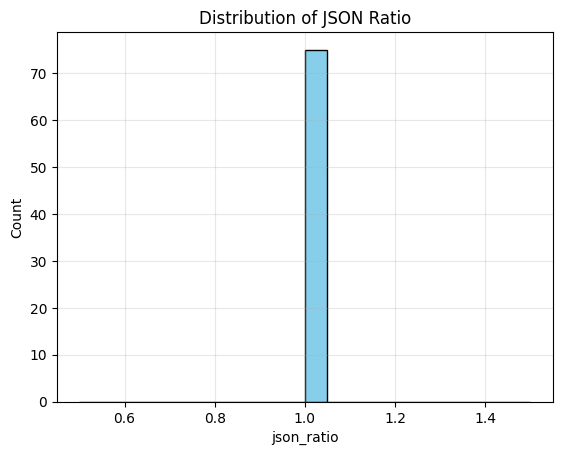


=== ⚠️ 누락 프레임 있는 비디오 목록 ===
Empty DataFrame
Columns: [file_name, n_extracted_frames, n_json_files, json_ratio, missing_frames]
Index: []

=== 🎬 MP4 존재 여부 ===
mp4_exists
True    75
Name: count, dtype: int64


In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
eda_video_metadata_checked.py

📌 기능:
- video_metadata_checked.csv 불러오기
- 전체 정보 확인
- json_ratio 분포 시각화
- 누락 프레임이 있는 비디오 목록 출력
- mp4 경로 존재 여부 검증
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import ast

# ---------------- 경로 ----------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata_checked.csv")

# ---------------- 데이터 로드 ----------------
df = pd.read_csv(CSV_PATH)

# missing_frames 문자열 → 리스트 변환
if "missing_frames" in df.columns:
    df["missing_frames"] = df["missing_frames"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
    )

print("=== 📊 기본 정보 ===")
print("데이터 크기:", df.shape)
print("\n컬럼 목록:", list(df.columns))

print("\n=== 📝 데이터 타입 ===")
print(df.dtypes)

print("\n=== 🔎 null 값 확인 ===")
print(df.isnull().sum())

# ---------------- 주요 통계 ----------------
print("\n=== 📈 수치 컬럼 요약 ===")
print(df.describe())

# JSON 비율 분포
if "json_ratio" in df.columns:
    plt.hist(df["json_ratio"], bins=20, color="skyblue", edgecolor="black")
    plt.title("Distribution of JSON Ratio")
    plt.xlabel("json_ratio")
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.show()

# ---------------- 누락 프레임 확인 ----------------
df_incomplete = df[df["json_ratio"] < 1]
print("\n=== ⚠️ 누락 프레임 있는 비디오 목록 ===")
print(df_incomplete[["file_name", "n_extracted_frames", "n_json_files", "json_ratio", "missing_frames"]].head(10))

# ---------------- MP4 경로 확인 ----------------
if "combined_overlay_mp4" in df.columns:
    df["mp4_exists"] = df["combined_overlay_mp4"].apply(lambda p: Path(str(p)).exists())
    print("\n=== 🎬 MP4 존재 여부 ===")
    print(df["mp4_exists"].value_counts())


📌 이동량 평균=1.56, 표준편차=1.53, threshold=6.16


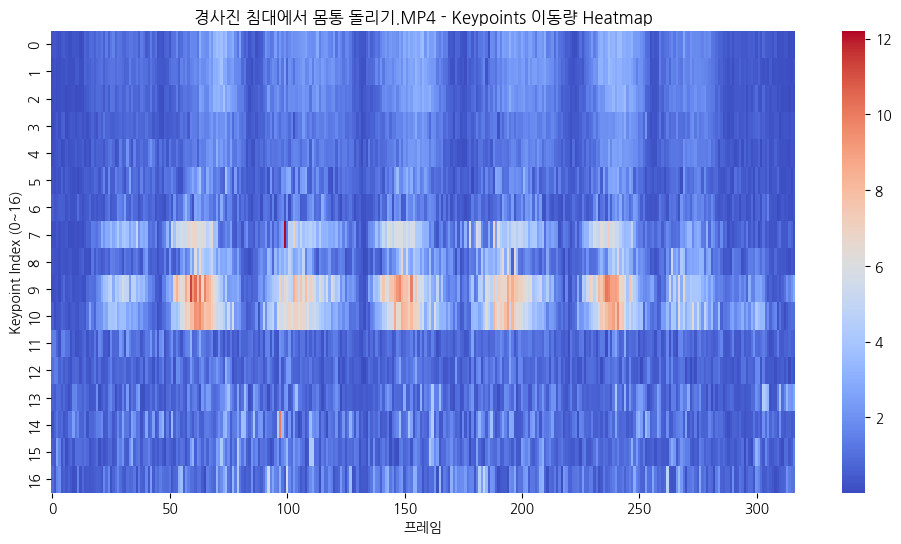

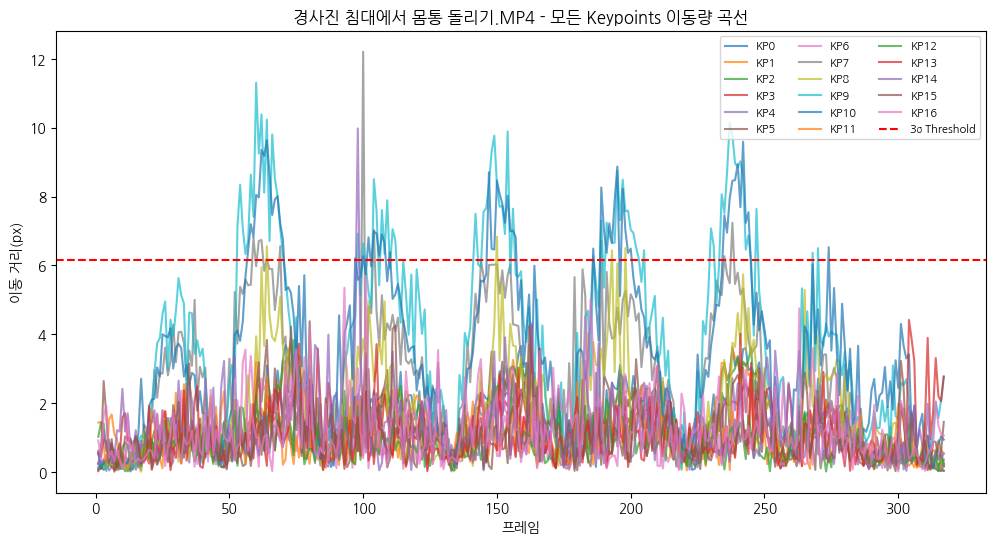

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
visualize_keypoint_motion_all.py

📌 기능:
- 특정 비디오 선택
- 프레임 간 모든 keypoints 이동량 계산
- Heatmap + 모든 keypoint 이동량 라인플롯 시#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
visualize_outlier_keypoints_by_index.py

📌 기능:
- CSV에서 특정 행 번호(target_idx)로 비디오 선택
- 프레임 간 keypoints 이동량 계산
- 순간적으로 확 튀는 keypoint만 찾아 시각화
"""

import cv2, json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- 한글 폰트 설정 ----------------
import matplotlib
plt.rcParams['font.family'] = 'NanumGothic'  # Linux
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
matplotlib.rcParams['axes.unicode_minus'] = False

# ---------------- 경로 ----------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata_checked.csv")

def load_keypoints(json_path):
    """JSON에서 keypoints 로드"""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not data.get("instance_info"):
        return None
    return np.array(data["instance_info"][0]["keypoints"])

def main():
    df = pd.read_csv(CSV_PATH)

    # 🎯 행 번호로 선택 (예: 5번째 → index=4)
    target_idx = 4
    row = df.iloc[target_idx]

    file_name = row["file_name"]
    frame_dir = Path(row["frames_dir"])
    keypoints_dir = Path(row["keypoints_dir"])

    print(f"🎬 선택한 비디오: {file_name}")

    # JSON 파일 로드
    json_files = sorted(keypoints_dir.glob("*.json"), key=lambda x: int(x.stem))

    seq = []
    for jp in json_files:
        kpts = load_keypoints(jp)
        if kpts is not None:
            seq.append((int(jp.stem), kpts))

    # 이동량 계산
    frame_idxs, motion = [], []
    for i in range(1, len(seq)):
        prev_idx, prev_kpts = seq[i-1]
        curr_idx, curr_kpts = seq[i]
        dist = np.linalg.norm(curr_kpts[:, :2] - prev_kpts[:, :2], axis=1)  # (17,)
        frame_idxs.append(curr_idx)
        motion.append(dist)
    motion = np.array(motion)

    # threshold 설정
    all_dists = motion.flatten()
    mean, std = np.mean(all_dists), np.std(all_dists)
    threshold = mean + 3 * std
    print(f"📌 이동량 평균={mean:.2f}, 표준편차={std:.2f}, threshold={threshold:.2f}")

    # outlier 탐색
    outliers = []
    for i, frame_idx in enumerate(frame_idxs):
        for kp_idx, dist in enumerate(motion[i]):
            if dist > threshold:
                outliers.append((frame_idx, kp_idx, dist))
    print(f"⚠️ Outlier keypoints 개수: {len(outliers)}")

    # ---------------- 시각화 (앞 3개만) ----------------
    for frame_idx, kp_idx, dist in outliers[:3]:
        img_path = frame_dir / f"{frame_idx:06d}.jpg"
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        kpts = load_keypoints(keypoints_dir / f"{frame_idx:06d}.json")

        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb)
        plt.axis("off")

        for i, (x, y, *_) in enumerate(kpts):
            if i == kp_idx:  # outlier keypoint
                plt.scatter(x, y, c="red", s=50, label=f"Outlier KP{i}")
            else:
                plt.scatter(x, y, c="lime", s=20)

        plt.title(f"{file_name} - 프레임 {frame_idx} (Outlier KP {kp_idx}, 이동 {dist:.1f})")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()
각화
"""

import cv2, json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- 한글 폰트 설정 ----------------
import matplotlib
plt.rcParams['font.family'] = 'NanumGothic'  # Linux
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
matplotlib.rcParams['axes.unicode_minus'] = False

# ---------------- 경로 ----------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata_checked.csv")

def load_keypoints(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not data.get("instance_info"):
        return None
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2 or 17,3)

def main():
    df = pd.read_csv(CSV_PATH)

    # 🎯 하나의 비디오 선택
    target_name = "경사진 침대에서 몸통 돌리기.MP4"
    row = df[df["file_name"] == target_name].iloc[0]

    keypoints_dir = Path(row["keypoints_dir"])
    json_files = sorted(keypoints_dir.glob("*.json"), key=lambda x: int(x.stem))

    # keypoints 시퀀스 로드
    seq = []
    for jp in json_files:
        kpts = load_keypoints(jp)
        if kpts is not None:
            seq.append((int(jp.stem), kpts))

    # 이동량 계산
    frame_idxs, motion = [], []
    for i in range(1, len(seq)):
        prev_idx, prev_kpts = seq[i-1]
        curr_idx, curr_kpts = seq[i]
        dist = np.linalg.norm(curr_kpts[:, :2] - prev_kpts[:, :2], axis=1)  # (17,)
        frame_idxs.append(curr_idx)
        motion.append(dist)
    motion = np.array(motion)  # shape: (num_frames-1, 17)

    # threshold 계산 (전체 이동량 기준)
    all_dists = motion.flatten()
    mean, std = np.mean(all_dists), np.std(all_dists)
    threshold = mean + 3 * std
    print(f"📌 이동량 평균={mean:.2f}, 표준편차={std:.2f}, threshold={threshold:.2f}")

    # ---------------- Heatmap ----------------
    plt.figure(figsize=(12,6))
    sns.heatmap(motion.T, cmap="coolwarm", cbar=True,
                xticklabels=50, yticklabels=[str(i) for i in range(motion.shape[1])])
    plt.xlabel("프레임")
    plt.ylabel("Keypoint Index (0~16)")
    plt.title(f"{target_name} - Keypoints 이동량 Heatmap")
    plt.show()

    # ---------------- 모든 keypoint 이동량 라인플롯 ----------------
    plt.figure(figsize=(12,6))
    for kp_idx in range(motion.shape[1]):
        plt.plot(frame_idxs, motion[:, kp_idx], label=f"KP{kp_idx}", alpha=0.7)
    plt.axhline(threshold, color="red", linestyle="--", label="3σ Threshold")
    plt.xlabel("프레임")
    plt.ylabel("이동 거리(px)")
    plt.title(f"{target_name} - 모든 Keypoints 이동량 곡선")
    plt.legend(ncol=3, fontsize=8)  # 범례 정리
    plt.show()

if __name__ == "__main__":
    main()


📌 이동량 평균=1.56, 표준편차=1.53, threshold=6.16
⚠️ Outlier keypoints 개수: 143


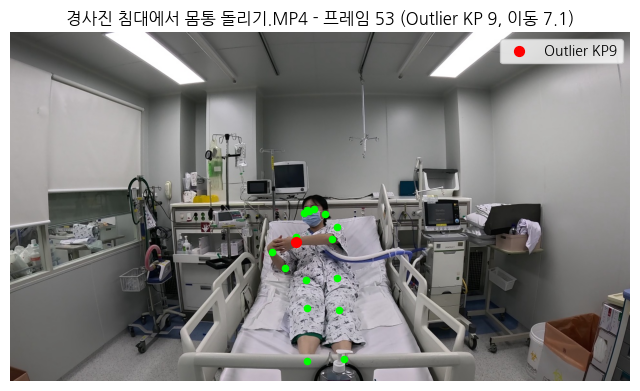

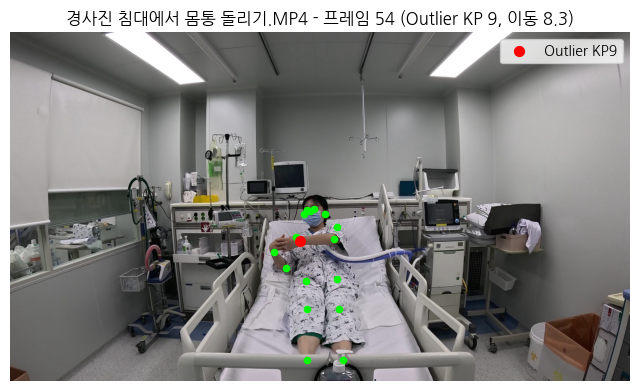

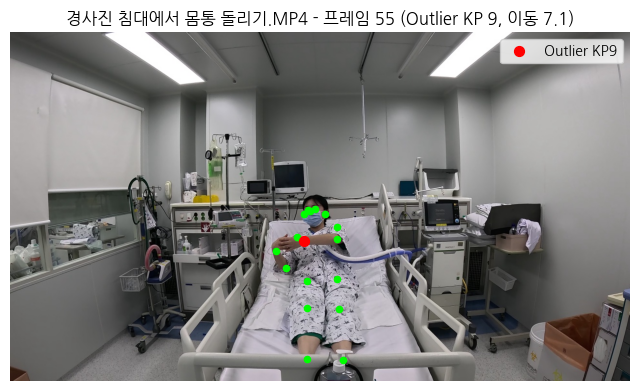

In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
visualize_outlier_keypoints.py

📌 기능:
- 특정 비디오 선택
- 프레임 간 이동량 계산
- 순간적으로 확 튀는 keypoint만 찾아 시각화
"""

import cv2, json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- 한글 폰트 설정 ----------------
import matplotlib
plt.rcParams['font.family'] = 'NanumGothic'  # Linux
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
matplotlib.rcParams['axes.unicode_minus'] = False

# ---------------- 경로 ----------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/new_data/video_metadata_checked.csv")

def load_keypoints(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not data.get("instance_info"):
        return None
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2 or 17,3)

def main():
    df = pd.read_csv(CSV_PATH)

    # 🎯 하나의 비디오 선택
    target_name = "경사진 침대에서 몸통 돌리기.MP4"
    row = df[df["file_name"] == target_name].iloc[0]

    frame_dir = Path(row["frames_dir"])
    keypoints_dir = Path(row["keypoints_dir"])

    # JSON 파일 로드
    json_files = sorted(keypoints_dir.glob("*.json"), key=lambda x: int(x.stem))

    seq = []
    for jp in json_files:
        kpts = load_keypoints(jp)
        if kpts is not None:
            seq.append((int(jp.stem), kpts))

    # 이동량 계산
    frame_idxs, motion = [], []
    for i in range(1, len(seq)):
        prev_idx, prev_kpts = seq[i-1]
        curr_idx, curr_kpts = seq[i]
        dist = np.linalg.norm(curr_kpts[:, :2] - prev_kpts[:, :2], axis=1)  # (17,)
        frame_idxs.append(curr_idx)
        motion.append(dist)
    motion = np.array(motion)  # shape: (num_frames-1, 17)

    # threshold 설정
    all_dists = motion.flatten()
    mean, std = np.mean(all_dists), np.std(all_dists)
    threshold = mean + 3 * std
    print(f"📌 이동량 평균={mean:.2f}, 표준편차={std:.2f}, threshold={threshold:.2f}")

    # outlier 지점 탐색
    outliers = []
    for i, frame_idx in enumerate(frame_idxs):
        for kp_idx, dist in enumerate(motion[i]):
            if dist > threshold:
                outliers.append((frame_idx, kp_idx, dist))
    print(f"⚠️ Outlier keypoints 개수: {len(outliers)}")

    # ---------------- 시각화 (앞 3개만) ----------------
    for frame_idx, kp_idx, dist in outliers[:3]:
        img_path = frame_dir / f"{frame_idx:06d}.jpg"
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        kpts = load_keypoints(keypoints_dir / f"{frame_idx:06d}.json")

        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb)
        plt.axis("off")

        for i, (x, y, *_) in enumerate(kpts):
            if i == kp_idx:  # outlier keypoint
                plt.scatter(x, y, c="red", s=50, label=f"Outlier KP{i}")
            else:
                plt.scatter(x, y, c="lime", s=20)

        plt.title(f"{target_name} - 프레임 {frame_idx} (Outlier KP {kp_idx}, 이동 {dist:.1f})")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()
